In [1]:
import pandas as pd
# 读取两个数据文件
df1 = pd.read_csv('002-气象-lanshanzui-merged.csv')
df2 = pd.read_csv('003-MCD18C2_061_20241027_插值填充_lanshanzui.csv')

# 将date列转换为datetime格式
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

# 按date列合并两个数据框
merged_df = pd.merge(df1, df2, on='date', how='outer')

# 按日期排序
merged_df = merged_df.sort_values('date')

# 保存合并后的数据
merged_df.to_csv('20-merged_all_data.csv', index=False)


In [ ]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 删除不需要的列
columns_to_drop = ['time', 'area', 'aqi', 'aqiLevel', 'aqiInfo', 'density_mean', 'density_lower', 'density_upper']
df = df.drop(columns=columns_to_drop)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)


In [5]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 添加风力大于等于4级的特征
df['wind_power_num'] = df['wind_power'].map(lambda x: 1 if x == '微风' else float(x.replace('级','')))
df['strong_wind'] = (df['wind_power_num'] >= 4).astype(int)

# 删除wind_power列
df = df.drop('wind_power', axis=1)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)


In [6]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 创建北风和西北风的one-hot编码
df['wind_north'] = df['wind_direction'].apply(lambda x: 1 if x in ['北风', '西北风'] else 0)

# 删除wind_direction列
df = df.drop('wind_direction', axis=1)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

In [7]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

# 创建大雨和暴雨的合并特征
df['weather_heavy_rain'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and ('大雨' in split_weather(x) or '暴雨' in split_weather(x)) else 0)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

In [8]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 创建温度大于25度的one-hot编码
df['temperature_high'] = (df['temperature'] > 25).astype(int)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

In [14]:
import numpy as np
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

# 创建天气权重
df['weather_weight'] = df['weather'].apply(lambda x: 1.0 if '晴' in split_weather(x) else (0.7 if '多云' in split_weather(x) else 0))

# 打印温度的最大值和最小值,检查数据
print("温度范围:", df['temperature'].min(), "-", df['temperature'].max())

# 计算温度效应 (使用25度作为阈值)
temp_effect = np.where(df['temperature'] > 25,
                      (df['temperature'] - 25) / (35 - 25), # 使用固定的温度范围,避免分母过大
                      0)

# 打印温度效应的统计信息
print("温度效应统计:")
print(pd.Series(temp_effect).describe())

# 创建天气-温度综合指数
df['weather_temp_index'] = df['weather_weight'] * temp_effect

# 打印最终指数的统计信息
print("天气-温度综合指数统计:")
print(df['weather_temp_index'].describe())

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

温度范围: 1.33 - 33.78
温度效应统计:
count    1308.000000
mean        0.071129
std         0.168039
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.878000
dtype: float64
天气-温度综合指数统计:
count    1308.000000
mean        0.040246
std         0.110729
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.614600
Name: weather_temp_index, dtype: float64


In [15]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 创建组合特征
# 1. 营养盐比值 (N/P比)
df['NP_ratio'] = df['TN'] / df['TP']

# 2. 温氧指数 (温度和溶解氧的乘积)
df['temp_oxygen_index'] = df['temperature'] * df['oxygen']

# 3. 富营养化指数 (基于氮磷和有机物)
df['eutrophication_index'] = (df['TN'] + df['TP'] + df['permanganate']) / 3

# 4. 水质综合指数 (pH、浊度和电导率的加权组合)
df['water_quality_index'] = (df['pH'] * 0.3 + df['turbidity'] * 0.4 + df['conductivity'] * 0.3)

# 5. 氮磷污染指数
df['nutrient_pollution_index'] = df['NH'] * df['TP']

# 6. 温度与pH的交互作用
df['temp_ph_interaction'] = df['temperature'] * df['pH']

# 7. 氨氮与总氮比值 (反映无机氮占比)
df['NH_TN_ratio'] = df['NH'] / df['TN']

# 8. 溶解氧饱和度指数 (考虑温度影响)
df['oxygen_saturation_index'] = df['oxygen'] / (14.652 - 0.41022 * df['temperature'] + 0.007991 * df['temperature']**2 - 0.000077774 * df['temperature']**3)

# 9. 营养盐限制因子 (最小营养盐法则)
df['nutrient_limitation'] = np.minimum(df['TN']/7.2, df['TP']/1)

# 10. 光照-浊度指数 (假设有光照数据，这里用浊度的倒数近似)
df['light_turbidity_index'] = 1 / (df['turbidity'] + 1)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

请你按照建议修改：

将TCN模型改为LSTM模型，并保持防止过拟合的特性和藻密度特征的权重增强。以下是主要的更改：

```python:root\Download\Modis-algae-aliyun\AlgaeBloomForecast-20241107\08-LSTM-单独计算藻密度-dropout-better+his-density-05.ipynb
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        # 特征权重层，为藻密度相关特征赋予更大权重
        initial_weights = torch.ones(input_size)
        density_indices = [i for i, name in enumerate(features) if 'density' in name]
        initial_weights[density_indices] = 2.0  # 藻密度特征权重加倍
        self.feature_weights = nn.Parameter(initial_weights)
        
        # 批归一化层
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # 使用双向LSTM
        )
        
        # 注意力机制
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=4)  # *2是因为双向LSTM
        
        # 全连接层，使用多层防止过拟合
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        # 残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        # 初始化权重
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # 应用特征权重
        weighted_x = x * self.feature_weights.view(1, 1, -1)
        
        # 批归一化
        batch_size, seq_len, features = weighted_x.size()
        weighted_x = weighted_x.transpose(1, 2)
        weighted_x = self.batch_norm(weighted_x)
        weighted_x = weighted_x.transpose(1, 2)
        
        # LSTM处理
        lstm_out, _ = self.lstm(weighted_x)
        
        # 注意力机制
        lstm_out = lstm_out.transpose(0, 1)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = attn_out.transpose(0, 1)
        
        # 取最后一个时间步
        out = attn_out[:, -1, :]
        
        # 全连接层
        out = self.fc_layers(out)
        
        # 残差连接
        residual = self.residual(weighted_x[:, -1, :])
        out = out + residual
        
        return out
```

主要改动说明：

1. **模型架构改进**：
   - 将TCN替换为双向LSTM
   - 保留了多头注意力机制
   - 使用了更深的全连接层网络

2. **防止过拟合的技术**：
   - 使用Dropout（在LSTM层和全连接层）
   - 批归一化（BatchNorm）
   - 双向LSTM提供更丰富的特征表示
   - 残差连接
   - 正则化的权重初始化

3. **藻密度特征权重增强**：
   - 在feature_weights初始化时，为藻密度相关特征赋予更大的权重（2.0）
   - 通过batch_norm进行特征标准化

4. **其他优化**：
   - 使用Xavier初始化和正交初始化优化权重初始化
   - 多层全连接网络带有BatchNorm和Dropout
   - 保留了残差连接以帮助训练

使用这个模型时，其他代码（如train_lstm_model、evaluate_lstm_model等）可以保持不变，只需要在main函数中将TCNModel替换为LSTMModel：

```python
# 在main函数中替换模型初始化部分
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.2)
```

2024-12-10 11:50:39,155 - INFO - Successfully loaded data file
2024-12-10 11:50:39,156 - INFO - 开始加载数据并预处理...
2024-12-10 11:50:39,193 - INFO - Step 1 - First 5 target values: [[0.05281572]
 [0.05281572]
 [0.05281572]
 [0.05128677]
 [0.04937559]]
2024-12-10 11:50:39,222 - INFO - Step 2 - First 5 target values: [[0.05281572]
 [0.05281572]
 [0.05128677]
 [0.04937559]
 [0.05166901]]
2024-12-10 11:50:39,256 - INFO - Step 3 - First 5 target values: [[0.05281572]
 [0.05128677]
 [0.04937559]
 [0.05166901]
 [0.05281572]]
2024-12-10 11:50:39,290 - INFO - Step 4 - First 5 target values: [[0.05128677]
 [0.04937559]
 [0.05166901]
 [0.05281572]
 [0.05128677]]
2024-12-10 11:50:39,335 - INFO - Step 5 - First 5 target values: [[0.04937559]
 [0.05166901]
 [0.05281572]
 [0.05128677]
 [0.0535802 ]]
2024-12-10 11:50:39,368 - INFO - Step 6 - First 5 target values: [[0.05166901]
 [0.05281572]
 [0.05128677]
 [0.0535802 ]
 [0.05778481]]
2024-12-10 11:50:39,406 - INFO - Step 7 - First 5 target values: [[0.05281

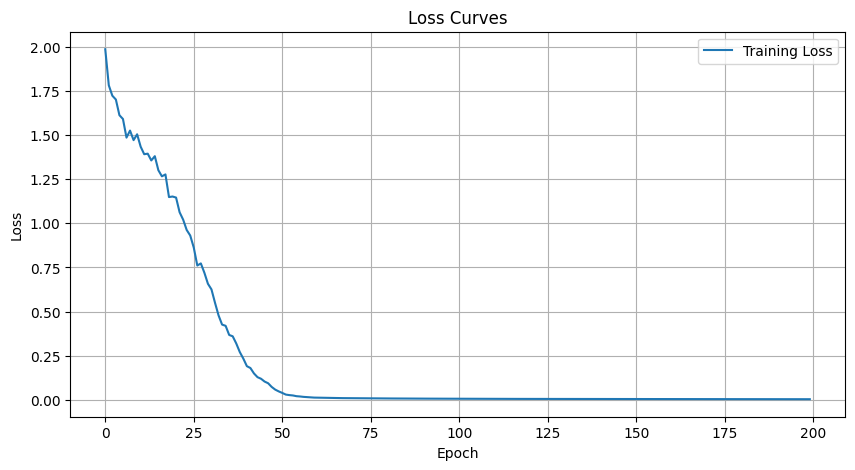

2024-12-10 12:21:55,677 - INFO - Final training loss: 0.0040
2024-12-10 12:21:56,254 - INFO - 提前1天预报 - RMSE: 0.0593, MAE: 0.0443
2024-12-10 12:21:56,255 - INFO - 
训练提前2天预报模型
2024-12-10 12:21:56,257 - INFO - Step 2 - First 5 target values: [[0.05281572]
 [0.05281572]
 [0.05128677]
 [0.04937559]
 [0.05166901]]
2024-12-10 12:22:59,648 - INFO - Epoch 10/200, Average Loss: 1.0681
2024-12-10 12:24:01,636 - INFO - Epoch 20/200, Average Loss: 0.8176
2024-12-10 12:25:06,707 - INFO - Epoch 30/200, Average Loss: 0.4081
2024-12-10 12:26:11,994 - INFO - Epoch 40/200, Average Loss: 0.1597
2024-12-10 12:27:15,467 - INFO - Epoch 50/200, Average Loss: 0.0305
2024-12-10 12:28:21,183 - INFO - Epoch 60/200, Average Loss: 0.0096
2024-12-10 12:29:32,102 - INFO - Epoch 70/200, Average Loss: 0.0057
2024-12-10 12:30:33,274 - INFO - Epoch 80/200, Average Loss: 0.0047
2024-12-10 12:31:36,367 - INFO - Epoch 90/200, Average Loss: 0.0042
2024-12-10 12:32:43,658 - INFO - Epoch 100/200, Average Loss: 0.0038
2024-12-1

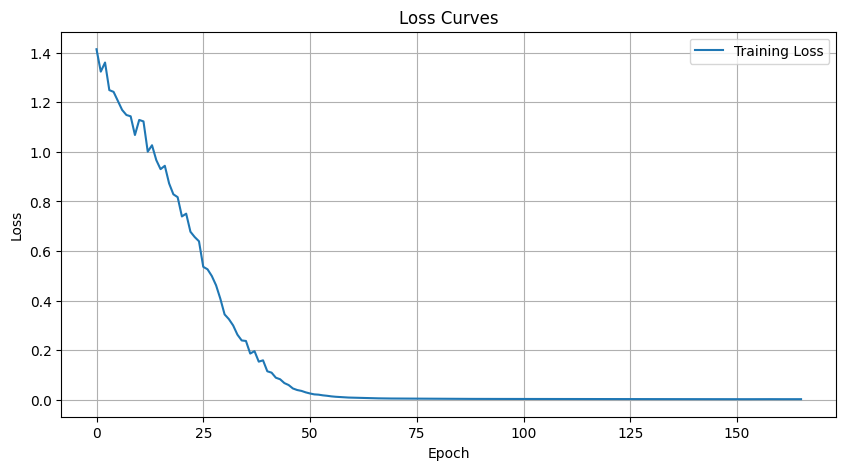

2024-12-10 12:39:45,361 - INFO - Final training loss: 0.0030
2024-12-10 12:39:45,855 - INFO - 提前2天预报 - RMSE: 0.0624, MAE: 0.0476
2024-12-10 12:39:45,856 - INFO - 
训练提前3天预报模型
2024-12-10 12:39:45,860 - INFO - Step 3 - First 5 target values: [[0.05281572]
 [0.05128677]
 [0.04937559]
 [0.05166901]
 [0.05281572]]
2024-12-10 12:40:57,850 - INFO - Epoch 10/200, Average Loss: 1.5798
2024-12-10 12:41:54,535 - INFO - Epoch 20/200, Average Loss: 1.1929
2024-12-10 12:42:46,336 - INFO - Epoch 30/200, Average Loss: 0.6820
2024-12-10 12:43:38,482 - INFO - Epoch 40/200, Average Loss: 0.2618
2024-12-10 12:44:30,240 - INFO - Epoch 50/200, Average Loss: 0.0745
2024-12-10 12:45:21,521 - INFO - Epoch 60/200, Average Loss: 0.0284
2024-12-10 12:46:14,973 - INFO - Epoch 70/200, Average Loss: 0.0132
2024-12-10 12:47:06,639 - INFO - Epoch 80/200, Average Loss: 0.0079
2024-12-10 12:47:57,795 - INFO - Epoch 90/200, Average Loss: 0.0061
2024-12-10 12:48:49,294 - INFO - Epoch 100/200, Average Loss: 0.0050
2024-12-1

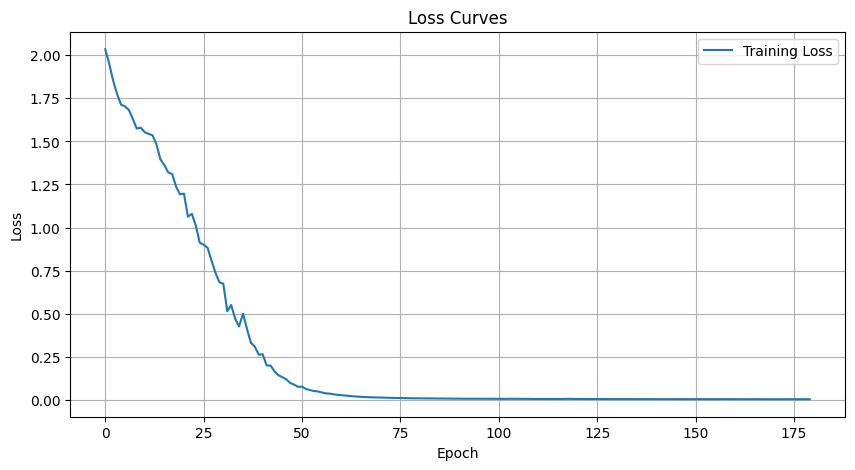

2024-12-10 12:55:38,769 - INFO - Final training loss: 0.0027
2024-12-10 12:55:39,088 - INFO - 提前3天预报 - RMSE: 0.1086, MAE: 0.0810
2024-12-10 12:55:39,089 - INFO - 
训练提前4天预报模型
2024-12-10 12:55:39,090 - INFO - Step 4 - First 5 target values: [[0.05128677]
 [0.04937559]
 [0.05166901]
 [0.05281572]
 [0.05128677]]
2024-12-10 12:56:25,893 - INFO - Epoch 10/200, Average Loss: 1.5569
2024-12-10 12:57:12,475 - INFO - Epoch 20/200, Average Loss: 1.1024
2024-12-10 12:57:59,004 - INFO - Epoch 30/200, Average Loss: 0.5813
2024-12-10 12:58:49,268 - INFO - Epoch 40/200, Average Loss: 0.2306
2024-12-10 12:59:39,272 - INFO - Epoch 50/200, Average Loss: 0.0540
2024-12-10 13:00:31,232 - INFO - Epoch 60/200, Average Loss: 0.0116
2024-12-10 13:01:22,792 - INFO - Epoch 70/200, Average Loss: 0.0065
2024-12-10 13:02:12,082 - INFO - Epoch 80/200, Average Loss: 0.0052
2024-12-10 13:03:03,126 - INFO - Epoch 90/200, Average Loss: 0.0046
2024-12-10 13:03:57,173 - INFO - Epoch 100/200, Average Loss: 0.0042
2024-12-1

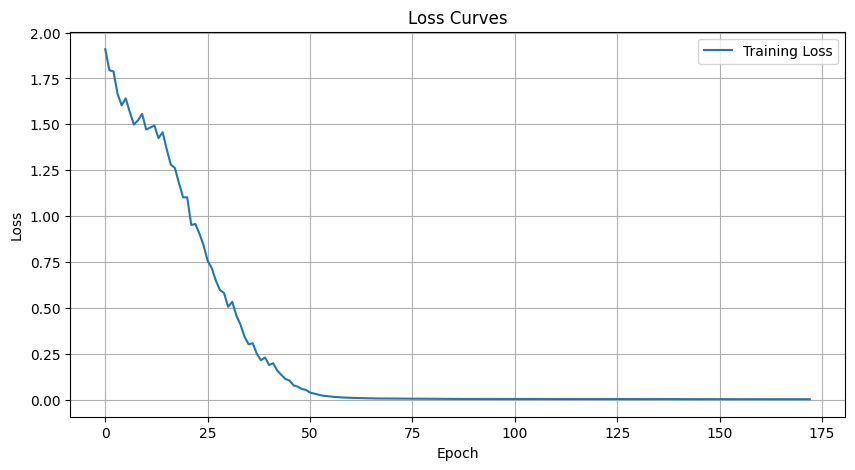

2024-12-10 13:09:59,472 - INFO - Final training loss: 0.0032
2024-12-10 13:09:59,671 - INFO - 提前4天预报 - RMSE: 0.1672, MAE: 0.1085
2024-12-10 13:09:59,672 - INFO - 
训练提前5天预报模型
2024-12-10 13:09:59,675 - INFO - Step 5 - First 5 target values: [[0.04937559]
 [0.05166901]
 [0.05281572]
 [0.05128677]
 [0.0535802 ]]
2024-12-10 13:10:45,498 - INFO - Epoch 10/200, Average Loss: 1.7093
2024-12-10 13:11:31,060 - INFO - Epoch 20/200, Average Loss: 1.3273
2024-12-10 13:12:20,721 - INFO - Epoch 30/200, Average Loss: 0.6421
2024-12-10 13:13:11,081 - INFO - Epoch 40/200, Average Loss: 0.2327
2024-12-10 13:13:58,729 - INFO - Epoch 50/200, Average Loss: 0.0500
2024-12-10 13:14:49,635 - INFO - Epoch 60/200, Average Loss: 0.0128
2024-12-10 13:15:40,314 - INFO - Epoch 70/200, Average Loss: 0.0065
2024-12-10 13:16:31,416 - INFO - Epoch 80/200, Average Loss: 0.0052
2024-12-10 13:17:21,313 - INFO - Epoch 90/200, Average Loss: 0.0044
2024-12-10 13:18:06,759 - INFO - Epoch 100/200, Average Loss: 0.0040
2024-12-1

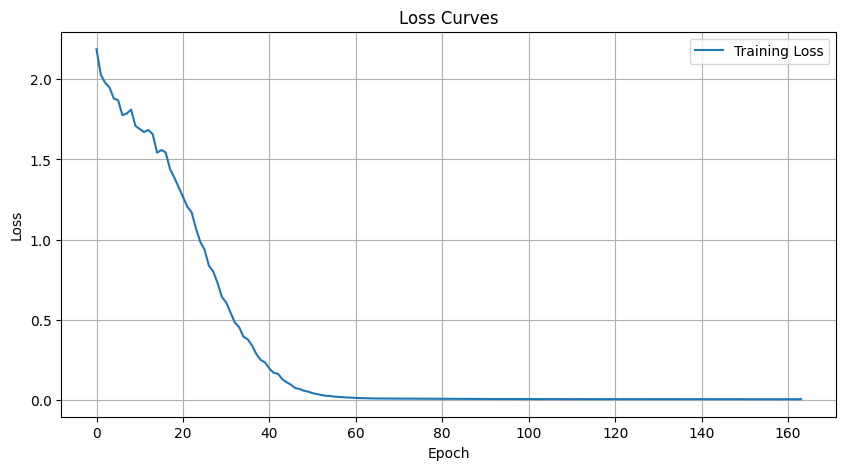

2024-12-10 13:23:23,175 - INFO - Final training loss: 0.0030
2024-12-10 13:23:23,544 - INFO - 提前5天预报 - RMSE: 0.0469, MAE: 0.0403
2024-12-10 13:23:23,545 - INFO - 
训练提前6天预报模型
2024-12-10 13:23:23,546 - INFO - Step 6 - First 5 target values: [[0.05166901]
 [0.05281572]
 [0.05128677]
 [0.0535802 ]
 [0.05778481]]
2024-12-10 13:24:14,177 - INFO - Epoch 10/200, Average Loss: 1.5590
2024-12-10 13:25:04,108 - INFO - Epoch 20/200, Average Loss: 1.1621
2024-12-10 13:25:51,592 - INFO - Epoch 30/200, Average Loss: 0.7028
2024-12-10 13:26:37,216 - INFO - Epoch 40/200, Average Loss: 0.2479
2024-12-10 13:27:22,859 - INFO - Epoch 50/200, Average Loss: 0.0578
2024-12-10 13:28:08,724 - INFO - Epoch 60/200, Average Loss: 0.0185
2024-12-10 13:28:56,385 - INFO - Epoch 70/200, Average Loss: 0.0101
2024-12-10 13:29:39,106 - INFO - Epoch 80/200, Average Loss: 0.0072
2024-12-10 13:30:21,270 - INFO - Epoch 90/200, Average Loss: 0.0060
2024-12-10 13:31:03,690 - INFO - Epoch 100/200, Average Loss: 0.0054
2024-12-1

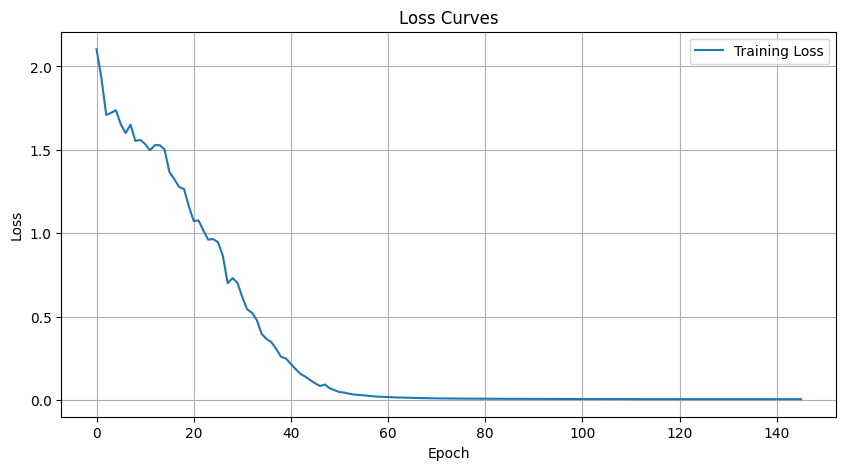

2024-12-10 13:34:35,588 - INFO - Final training loss: 0.0042
2024-12-10 13:34:35,889 - INFO - 提前6天预报 - RMSE: 0.0930, MAE: 0.0779
2024-12-10 13:34:35,890 - INFO - 
训练提前7天预报模型
2024-12-10 13:34:35,891 - INFO - Step 7 - First 5 target values: [[0.05281572]
 [0.05128677]
 [0.0535802 ]
 [0.05778481]
 [0.06390061]]
2024-12-10 13:35:26,329 - INFO - Epoch 10/200, Average Loss: 1.7803
2024-12-10 13:36:15,281 - INFO - Epoch 20/200, Average Loss: 1.3895
2024-12-10 13:37:04,415 - INFO - Epoch 30/200, Average Loss: 0.6739
2024-12-10 13:37:52,116 - INFO - Epoch 40/200, Average Loss: 0.2441
2024-12-10 13:38:40,437 - INFO - Epoch 50/200, Average Loss: 0.0714
2024-12-10 13:39:27,135 - INFO - Epoch 60/200, Average Loss: 0.0238
2024-12-10 13:40:15,556 - INFO - Epoch 70/200, Average Loss: 0.0135
2024-12-10 13:41:04,802 - INFO - Epoch 80/200, Average Loss: 0.0099
2024-12-10 13:41:53,309 - INFO - Epoch 90/200, Average Loss: 0.0085
2024-12-10 13:42:40,546 - INFO - Epoch 100/200, Average Loss: 0.0074
2024-12-1

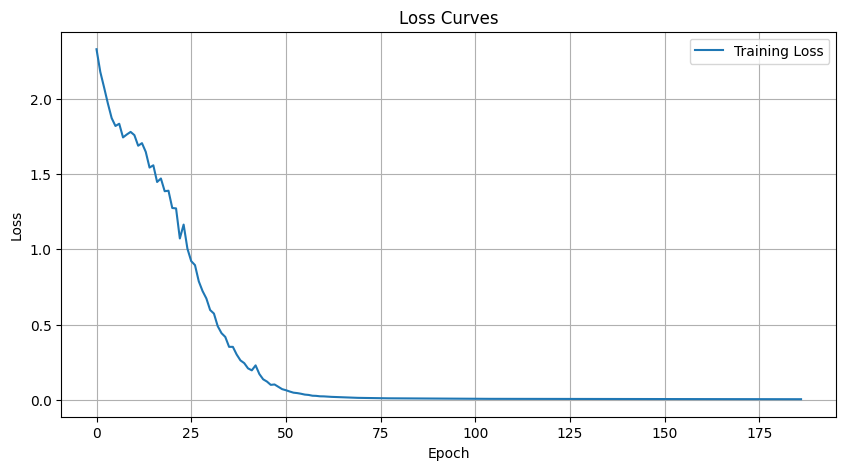

2024-12-10 13:49:32,366 - INFO - Final training loss: 0.0044
2024-12-10 13:49:32,619 - INFO - 提前7天预报 - RMSE: 0.1208, MAE: 0.0921
/tmp/ipykernel_1633/1815185123.py:317: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1633/1815185123.py:317: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1633/1815185123.py:317: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1633/1815185123.py:317: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1633/1815185123.py:317: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1633/1815185123.py:317: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/

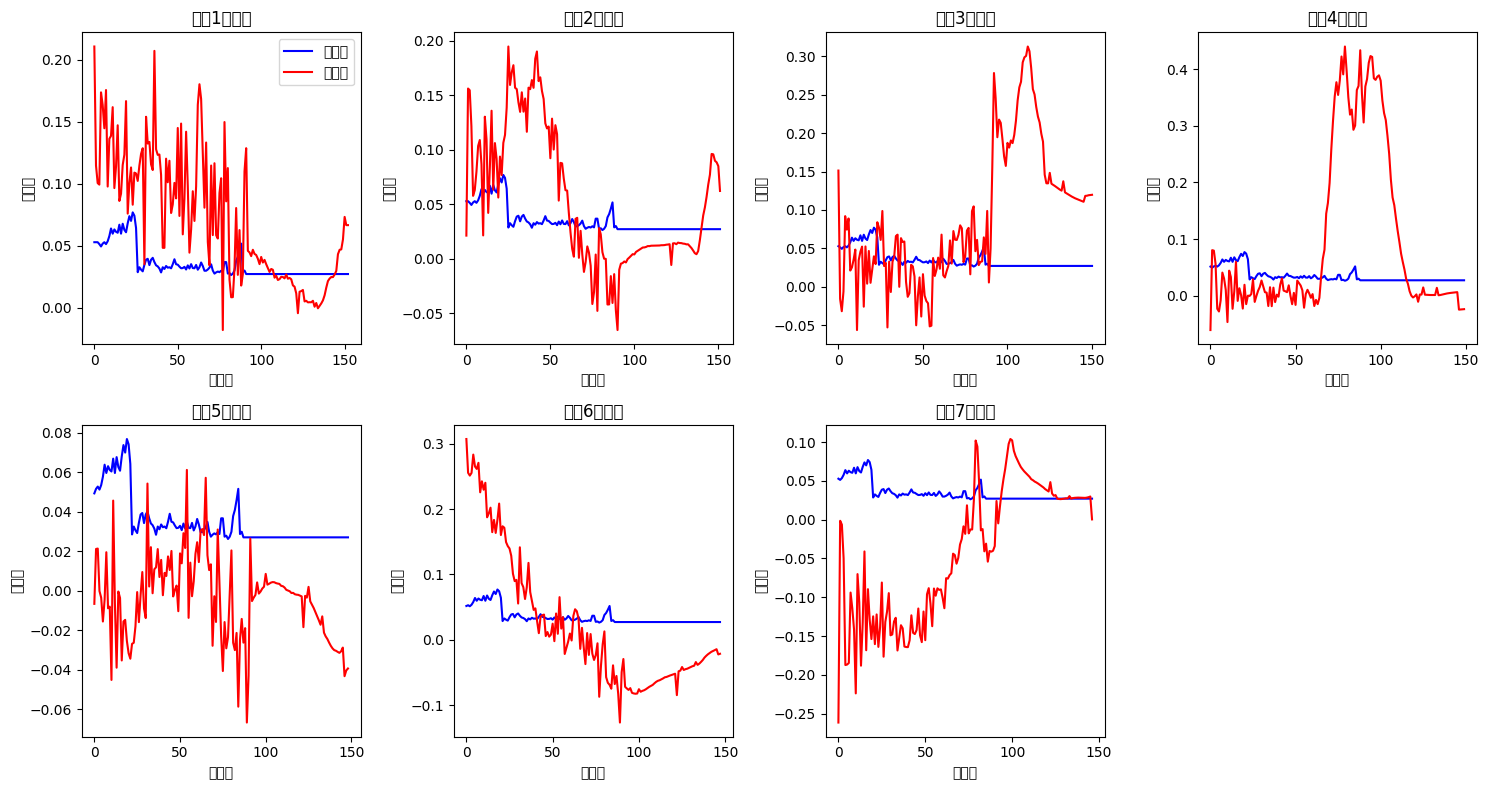

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

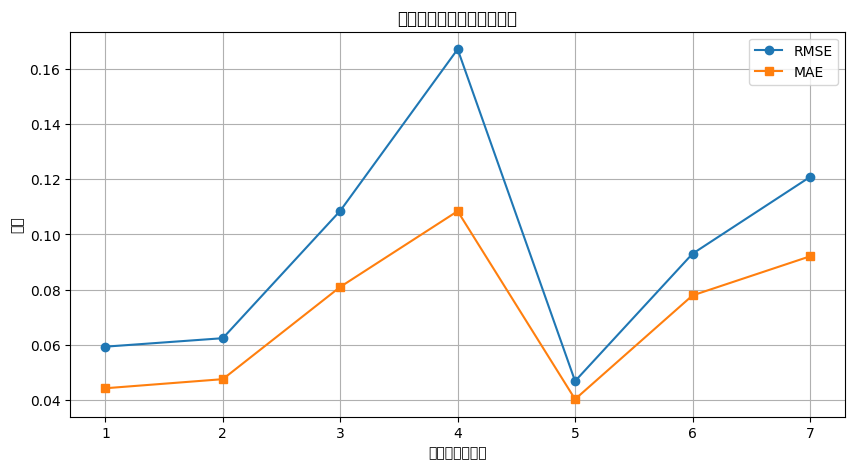

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class WeightedHuberLoss(nn.Module):
    def __init__(self, density_weight=2.0):
        super(WeightedHuberLoss, self).__init__()
        self.base_criterion = nn.HuberLoss()
        self.density_weight = density_weight

    def forward(self, pred, target):
        base_loss = self.base_criterion(pred, target)
        return base_loss * self.density_weight

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        # 特征权重层
        self.feature_weights = nn.Parameter(torch.ones(input_size))
        
        # 批归一化层
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # 注意力机制
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=4)
        
        # 全连接层
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        # 残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        # 初始化权重
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # 应用特征权重
        weighted_x = x * self.feature_weights.view(1, 1, -1)
        
        # 批归一化
        batch_size, seq_len, features = weighted_x.size()
        weighted_x = weighted_x.transpose(1, 2)
        weighted_x = self.batch_norm(weighted_x)
        weighted_x = weighted_x.transpose(1, 2)
        
        # LSTM处理
        lstm_out, _ = self.lstm(weighted_x)
        
        # 注意力机制
        lstm_out = lstm_out.transpose(0, 1)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = attn_out.transpose(0, 1)
        
        # 取最后一个时间步
        out = attn_out[:, -1, :]
        
        # 全连接层
        out = self.fc_layers(out)
        
        # 残差连接
        residual = self.residual(weighted_x[:, -1, :])
        out = out + residual
        
        return out

def preprocess_data(df, sequence_length, max_prediction_step=7):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    # 选择指定的特征
    selected_features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                        'turbidity', 'chla', 'density', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                        'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                        'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                        'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                        'strong_wind']
    
    df_features = df[selected_features]
    
    # 使用MinMaxScaler进行特征缩放
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_features),
        columns=selected_features,
        index=df.index
    )

    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    train_data_dict = {}
    test_data_dict = {}
    
    for step in range(1, max_prediction_step + 1):
        train_sequences = []
        for i in range(len(train_data) - sequence_length - step + 1):
            train_sequences.append(train_data.iloc[i:i+sequence_length+step].values)
        train_sequences = np.array(train_sequences)
        
        test_sequences = []
        for i in range(len(test_data) - sequence_length - step + 1):
            test_sequences.append(test_data.iloc[i:i+sequence_length+step].values)
        test_sequences = np.array(test_sequences)
        
        X_train = train_sequences[:, :sequence_length, :]
        y_train = train_sequences[:, -1, [selected_features.index('density')]]
        
        X_test = test_sequences[:, :sequence_length, :]
        y_test = test_sequences[:, -1, [selected_features.index('density')]]
        
        train_data_dict[step] = (X_train, y_train)
        test_data_dict[step] = (X_test, y_test)
        
        logging.info(f"Step {step} - First 5 target values: {y_test[:5]}")
    
    return train_data_dict, test_data_dict, scaler, selected_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15
    no_improve = 0
    min_delta = 0.0001
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('20-merged_all_data.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 3
        output_size = 1
        criterion = WeightedHuberLoss(density_weight=2.0)
        epochs = 200
        max_prediction_step = 7
        sequence_length = 60

        logging.info("开始加载数据并预处理...")
        train_data_dict, test_data_dict, scaler, features = preprocess_data(
            df, sequence_length, max_prediction_step)
        
        input_size = len(features)
        logging.info(f"输入特征维度: {input_size}")
        
        results = {}
        
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            logging.info(f"Step {step} - First 5 target values: {y_test[:5]}")
            
            train_loader, test_loader = create_dataloaders(
                X_train, y_train, X_test, y_test, batch_size)
            
            model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.2)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)
            scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=epochs,
                                 steps_per_epoch=len(train_loader),
                                 pct_start=0.3, div_factor=10.0)
            
            train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)
            predictions, targets = evaluate_lstm_model(model, test_loader)
            
            rmse = np.sqrt(mean_squared_error(targets, predictions))
            mae = mean_absolute_error(targets, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': targets,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        plt.figure(figsize=(15, 8))
        for step in range(1, max_prediction_step + 1):
            plt.subplot(2, 4, step)
            plt.plot(results[step]['targets'], label='实际值', color='blue')
            plt.plot(results[step]['predictions'], label='预测值', color='red')
            plt.title(f'提前{step}天预报')
            plt.xlabel('时间步')
            plt.ylabel('藻密度')
            if step == 1:
                plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        steps = list(results.keys())
        rmse_values = [results[step]['rmse'] for step in steps]
        mae_values = [results[step]['mae'] for step in steps]
        
        plt.plot(steps, rmse_values, 'o-', label='RMSE')
        plt.plot(steps, mae_values, 's-', label='MAE')
        plt.xlabel('预测步长（天）')
        plt.ylabel('误差')
        plt.title('预测误差随预测步长的变化')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()